In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import json

df = pd.read_csv('CLEANED_WA_Fn-UseC_-Telco-Customer-Churn.csv')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna(subset=['TotalCharges'])

In [2]:
target = 'Churn'
all_features = [
    'gender','SeniorCitizen','Partner','Dependents','tenure','PhoneService',
    'MultipleLines','InternetService','OnlineSecurity','OnlineBackup',
    'DeviceProtection','TechSupport','StreamingTV','StreamingMovies',
    'Contract','PaperlessBilling','PaymentMethod','MonthlyCharges','TotalCharges'
]
reduced_features = [f for f in all_features if f not in ['TotalCharges','gender','PhoneService']]


In [3]:
X = df[all_features]
y = df[target].map({'Yes': 1, 'No': 0})
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train_red = X_train_full[reduced_features]
X_test_red = X_test_full[reduced_features]

In [4]:
# 4. Preprocessing
# Ordinal encoding for 'Contract'
ordinal_enc = OrdinalEncoder(categories=[['Month-to-month', 'One year', 'Two year']])

cat_full = [col for col in all_features if df[col].dtype == 'object' and col != 'Contract']
num_full = ['tenure', 'MonthlyCharges', 'TotalCharges']

cat_red = [col for col in reduced_features if df[col].dtype == 'object' and col != 'Contract']
num_red = ['tenure', 'MonthlyCharges']


In [5]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer


preprocessor_full = ColumnTransformer([
    ("ord_contract", OrdinalEncoder(categories=[['Month-to-month','One year','Two year']]),["Contract"]),
    ("onehot", OneHotEncoder(drop="first", sparse_output=False), cat_full),
    ("scale", StandardScaler(), num_full),
])

preprocessor_red = ColumnTransformer([
    ("ord_contract", OrdinalEncoder(categories=[['Month-to-month','One year','Two year']]), ["Contract"]),
    ("onehot", OneHotEncoder(drop="first", sparse_output=False), cat_red),
    ("scale",   StandardScaler(), num_red),
])


In [7]:
pipe_full = Pipeline([
    ('pre', preprocessor_full),
    ('rf', RandomForestClassifier(random_state=42))
])

pipe_red = Pipeline([
    ('pre', preprocessor_red),
    ('rf', RandomForestClassifier(random_state=42))
])


In [11]:
#parameters grid
param_grid_rf = {
    'rf__n_estimators': range(100, 500, 100),
    'rf__max_features': ['sqrt', 'log2', None],
    'rf__max_depth': [None, 10, 20]
}


In [23]:
# Perform Grid Search
grid_search = GridSearchCV(
    estimator=pipe_red,
    param_grid=param_grid_rf,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)

In [26]:
print("Running grid search...")
grid_search.fit(X_train_red, y_train)

# Evaluate best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_red)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("\n=== BEST MODEL REPORT ===")
print(report)
print("Confusion Matrix:")
print(cm)

# Save best model
joblib.dump(best_model, 'rf_telco_tuned_pipeline.pkl')
print("\nTuned model saved as 'rf_telco_tuned_pipeline.pkl'")


Running grid search...

=== BEST MODEL REPORT ===
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.62      0.52      0.57       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407

Confusion Matrix:
[[916 117]
 [180 194]]

Tuned model saved as 'rf_telco_tuned_pipeline.pkl'


In [27]:
# print out best parameters on reduced model
print(grid_search.best_params_)

{'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__n_estimators': 400}


<Figure size 1000x600 with 0 Axes>

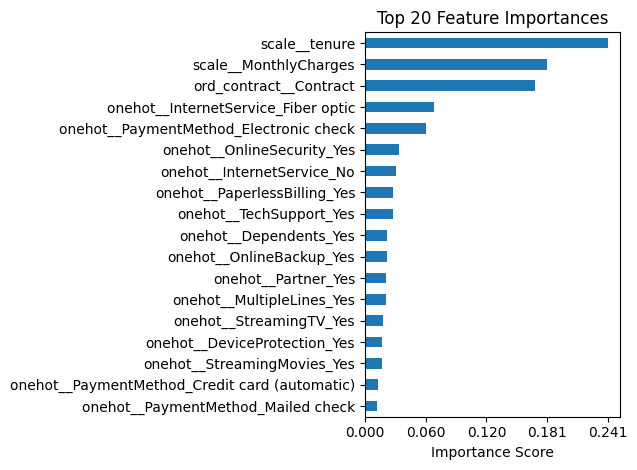

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# Extract trained RandomForest from the best model
rf = best_model.named_steps['rf']

# Extract feature names from the preprocessor
preprocessor = best_model.named_steps['pre']
feature_names = preprocessor.get_feature_names_out()

# Create DataFrame of feature importances
feature_imp = pd.DataFrame({
    'importance': rf.feature_importances_
}, index=feature_names)

# Sort and take top 20
top_n = 20
feature_imp_top = feature_imp.sort_values(by='importance', ascending=False).head(top_n)

# Plot
plt.figure(figsize=(10, 6))
feature_imp_top.plot(kind='barh', legend=False)
plt.gca().invert_yaxis()
plt.title(f"Top {top_n} Feature Importances")
plt.xlabel("Importance Score")

# Format x-axis ticks
# disable scientific notation
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(
    ticks=np.linspace(0, feature_imp_top['importance'].max(), num=5),  # evenly spaced ticks
    labels=[f"{x:.3f}" for x in np.linspace(0, feature_imp_top['importance'].max(), num=5)]
)

plt.tight_layout()
plt.show()


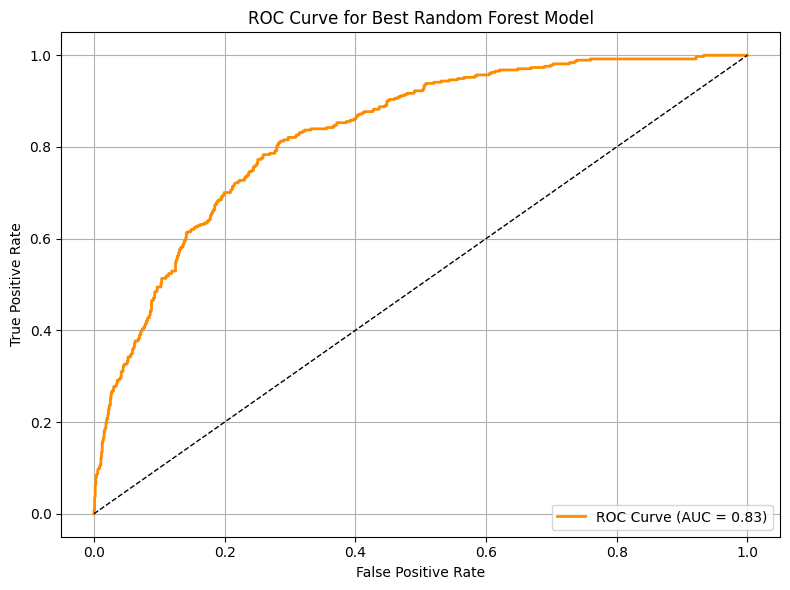

In [38]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class (churn = 1)
y_proba = best_model.predict_proba(X_test_red)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='black', linestyle='--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Best Random Forest Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


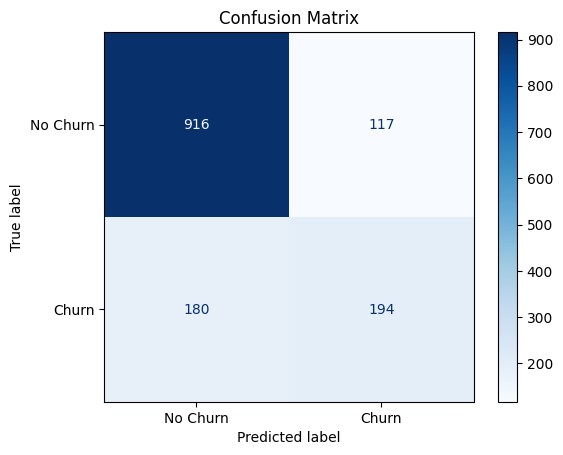

In [39]:
# confusion matrix of best random forest model
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Churn', 'Churn'])

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
